# Librerías

In [1]:
from bs4 import BeautifulSoup # type: ignore
import requests # type: ignore
import pandas as pd # type: ignore
from datetime import date,timedelta,datetime
import time
import seaborn as sns # type: ignore
import matplotlib.pyplot as plt # type: ignore
import csv
import re
import sqlalchemy # type: ignore
import sqlalchemy # type: ignore
import pyodbc # type: ignore
from sqlalchemy.engine import * # type: ignore
from sqlalchemy.orm import * # type: ignore
from sqlalchemy import * # type: ignore
from sqlalchemy import update # type: ignore
from typing import List
from typing import Optional
from typing import Any, TYPE_CHECKING

import os
import numpy as np # type: ignore
import warnings
warnings.filterwarnings('ignore')


# Desarrollo

## Funciones comunes

In [2]:
estaciones_elegidas = pd.read_excel('./info_wunder.xlsx','estaciones')

In [3]:
df_cuentas_wunder=pd.read_excel('./info_wunder.xlsx','apiKeys',skiprows=2)
api_keys=df_cuentas_wunder['apiKey']
api_keys=list(api_keys)
api_keys


['66d6d2df24cb428a96d2df24cbc28ad4',
 '2efc62145baa4503bc62145baac50320',
 '17ae9bc6979c4f94ae9bc6979c2f94be',
 '3061cd3105fb4d04a1cd3105fb3d04f5',
 'e973d41675604a8fb3d41675603a8ff9',
 '8bc93c50250c46aa893c50250c96aadf',
 'd067936f17814b7ca7936f1781cb7c1b',
 '08f138f5654748c5b138f5654758c5a4',
 '8c92a311e735492392a311e735d9237a',
 'dde8c7d371bc419aa8c7d371bc519afc',
 '6d59e6d09ba3475e99e6d09ba3b75e6e',
 '138d67d38eb74ca48d67d38eb75ca4ab',
 'c188728eab2a419b88728eab2aa19b25',
 '9303edaba7304a9583edaba7300a957d',
 '0f0e22e43a7a43e88e22e43a7a83e8da',
 '243492574df94a8cb492574df9ea8c05',
 'e63848374c6d4d40b848374c6dad4079',
 '0c14813f1b8b407694813f1b8bb076e2',
 '54b23a5618e44f6eb23a5618e41f6e9c',
 '4dbccecd242a4f3cbccecd242a2f3cb5',
 'e1038f8b4ca14ca4838f8b4ca1aca47a',
 'fc16f61266a149a596f61266a179a57d',
 'dfc0485c358144c880485c3581e4c847',
 '55e505190b3d4cb8a505190b3d0cb8a1',
 'fbe797d9a97b4dd8a797d9a97b0dd8c2',
 '9224a923c2304f37a4a923c2300f37f1',
 'afd41505a3b74a9b941505a3b7aa9bd9',
 

In [4]:
def extraer_campos_utiles(observaciones:list,dia:date,stationId:str=None)->list:
    """retorna un mensaje en torno a las observaciones agregadas
    y la fecha de la última observacoin agregada"""
    observaciones_filtrada=[]
    # Reportes completos
    if (len(observaciones)==288):
        # dia_con_obs=1 | dia_completo=1
        for observacion in observaciones:
            observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal'],1,1]
            observaciones_filtrada.append(observacion_filtrada)    
    # Reportes Incompletos
    elif ((len(observaciones)>0)):
        # dia_con_obs=1 | dia_completo=0
        for observacion in observaciones:
            observacion_filtrada = [observacion['stationID'],observacion['lat'],observacion['lon'],observacion['obsTimeLocal'],observacion['winddirAvg'],observacion['metric']['windspeedAvg'],observacion['metric']['windgustAvg'],observacion['metric']['precipRate'],observacion['metric']['precipTotal'],1,0]
            observaciones_filtrada.append(observacion_filtrada)    
    #No hubo reportes
    else:
        observacion_filtrada = [stationId,None,None,dia,None,None,None,None,None,0,0]
        observaciones_filtrada.append(observacion_filtrada)    
    return observaciones_filtrada     


In [5]:
def construirObservacion(obs:dict,campos:tuple)->list:
    """ Recibe una observación en formato diccionario y los campos de interés como tupla. 
    Devuelve una lista con los valores de los campos de interés """
    var_sin_unidad=["stationID","tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
    observacion=[]
    for campo in campos:
        if campo in var_sin_unidad:
            observacion.append(obs[campo])
        else:
            observacion.append(obs['metric'][campo])    
    return observacion        

In [6]:
""" construirObservacion({'tz':'Darío','metric':{"tempHigh":'Facundo'}},('tz','tempHigh')) """

' construirObservacion({\'tz\':\'Darío\',\'metric\':{"tempHigh":\'Facundo\'}},(\'tz\',\'tempHigh\')) '

In [7]:
def extraer_campos(observaciones:list,dia:date,stationId:str,variables:tuple)->list:
    """retorna un mensaje en torno a las observaciones agregadas
    y la fecha de la última observacoin agregada"""
    obs=[]
    #No hubo reportes
    if (len(observaciones)==0):
        observacion = [stationId,None,None,dia,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,0,0]
        obs.append(observacion)    
    else:
        # Reportes completos
        if (len(observaciones)==288):
            # dia_con_obs=1 | dia_completo=1
            for observacion in observaciones:
                observacion = construirObservacion(observacion,variables)
                observacion+=[1,1]
                obs.append(observacion)    
        # Reportes Incompletos
        else:
            # dia_con_obs=1 | dia_completo=0
            for observacion in observaciones:
                observacion = construirObservacion(observacion,variables)
                observacion+=[1,0]
                obs.append(observacion)  
    return obs 

In [8]:
def cambiar_api_key(conjunto_api_key:list[str],api_key_actual:str)->str:
    indice_api_key_actual=conjunto_api_key.index(api_key_actual)
    if indice_api_key_actual==len(conjunto_api_key)-1:
        return ''
    else:
        siguiente_api_key=conjunto_api_key[indice_api_key_actual+1]
        return siguiente_api_key


In [9]:
#cambiar_api_key(api_keys,'0f80b73561fe451b80b73561fe651b08')

In [10]:
def imprimir_mensaje(situacion:str,vieja_api_key:str=None,url:str=None,llamadas_totales:int=None,
    identificador_estacion:str=None,dia:date=None,status_code:int=None,n_error_con:int=None,problema=None)->None:
    #Se agotó el cupo de llamadas por api key
    if (situacion=='llamada 1400'):
        print(f'cambio de api key por llamada 1400. Vieja api key\n{vieja_api_key}')
    #La api key no tiene autorización
    elif (situacion=='api key desautorizada'):
        print(f'cambio de api key por problmeas de autorización.\nRespuesta:{status_code}.\nVieja api key\n{vieja_api_key}')
    #El servidor no responde
    elif (situacion=='el servidor no contesta'):
        print(f'Problemas con el servidor web.\nRespuesta:{status_code}.\nSe pausa durante una hora la ejecución.\nHora de pausa:{datetime.now()}')
    elif (situacion=='respesta del servidor desconocida'):
        print(f'Se obtuvo una respuesta desconocida.\nRespuesta:{status_code}.\nLlamado:{url}')
    elif (situacion=='error de conexión'):
        print(f'Hubo un problema con la conexión al servidor.\nError número:{n_error_con}.\nError:{problema}\nSe aguarda 1 minuto')  
    #Se agotaron todas las api keys
    elif(situacion=='sin api keys'):
        print(f'se consumieron todas las api keys disponibles.\nÚltimo llamado:{url}.')
    #La estación registró 30 días consecutivos sin reportes
    elif(situacion=='cambio estacion'):
        print(f'se cargaron todas las observacines de {identificador_estacion}')
    elif(situacion=='fin ejecución'):
        print(f'Finalizó la ejecucución del programa.\nTotal de llamadas:{llamadas_totales}')


In [11]:
""" imprimir_mensaje(situacion='llamada 1400',vieja_api_key='ad2')
imprimir_mensaje(situacion='cambio de estacion',identificador_estacion='ros')
imprimir_mensaje(situacion='api key desautorizada',status_code=401,vieja_api_key='as')
imprimir_mensaje(situacion='sin api keys',url='https',llamadas_totales=102)
imprimir_mensaje(situacion='el servidor no contesta',status_code=500)
imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=403,url='https')   
imprimir_mensaje(situacion='error de conexión',n_error_con=3,problema='error SSL')    
imprimir_mensaje(situacion='ejecucion exitosa',llamadas_totales=689)     """

" imprimir_mensaje(situacion='llamada 1400',vieja_api_key='ad2')\nimprimir_mensaje(situacion='cambio de estacion',identificador_estacion='ros')\nimprimir_mensaje(situacion='api key desautorizada',status_code=401,vieja_api_key='as')\nimprimir_mensaje(situacion='sin api keys',url='https',llamadas_totales=102)\nimprimir_mensaje(situacion='el servidor no contesta',status_code=500)\nimprimir_mensaje(situacion='respesta del servidor desconocida',status_code=403,url='https')   \nimprimir_mensaje(situacion='error de conexión',n_error_con=3,problema='error SSL')    \nimprimir_mensaje(situacion='ejecucion exitosa',llamadas_totales=689)     "

In [12]:
def escribirCSV(ruta:str,datos:list,campos_encabezado:tuple)->None:
    #Se elige el modo escritura(w) por lo que se sobreescribe el archivo
    with open(ruta,'w',newline='') as csv_file:
            writer = csv.writer(csv_file)
            header = [campo for campo in campos_encabezado]
            writer.writerow(header) 
            writer.writerows(datos)

In [13]:
#escribirCSV(ruta='ejemplo.csv',datos=[['facundo','2024/9/7'],['mariana','2023/9/7']],campos_encabezado=('nombre','fecha'))

## Inicio observaciones

In [2]:
def buscar_primer_registro(id_estacion:str,año:int,mes:int,hasta_año:int,hasta_mes:int)->str:
    """retorna un dato que puede ser la fecha del primer registro o un mensaje 
    en caso que no se haya encontrado el primer registros"""
    n_quebro=1
    numero_llamada=1
    while True:
        URL = f"https://www.wunderground.com/dashboard/pws/{id_estacion}/table/{año}-{mes}-1/{año}-{mes}-1/monthly"
        r = requests.get(URL)
        soup = BeautifulSoup(r.text,'lxml')
        titulo=soup.find('h1').text
        # Error 404 puede obedecer a que la estación no exista
        if titulo=='Error 404: Page Not Found':
            t_cuerpo=None
            break
        tabla = soup.find('table',{'class':'history-table desktop-table'})
        try:
            t_cuerpo=tabla.find('tbody')
            numero_llamada+=1
        # La plataforma a veces no devuelve el recurso solicitado. Se probó la sentencia continue para repetir, pero reitera el error       
        except AttributeError:
            t_cuerpo=None
            #continue
            break
        # Si el cuerpo de la tabla no es un string vacío significa que SÍ hay registros para la fecha consultada
        if (t_cuerpo.text!=''):
            break
        # Si se llegó a la fecha límite significa que la estación nunca tuvo registros
        elif(año==hasta_año and mes==hasta_mes):
            break
        # Se consulta si subo registros el mes siguiente
        else:
            mes+=1
            if mes==13:
                año+=1
                mes=1       
    if (t_cuerpo is None):
        mensaje=f"problema con solicitud {URL}"   
    elif (t_cuerpo.text==''):
        mensaje='no se encontraron observaciones'
    else:
        fecha=t_cuerpo.find('td').text
        mes,dia,año=fecha.split('/')
        fecha=f"{año}/{mes}/{dia}"
        mensaje=fecha
    return mensaje 

In [20]:
def reescribir_inicio_estaciones(estaciones_id:pd.DataFrame)->None:
    inicio_reportes=[]
    for r in estaciones_id.iterrows(): 
        i,s=r
        estacion=s.loc['estaciones_id']
        dato=s.loc['fecha_inicio']
        hubo_problema=True if dato.find('p')!=-1 else False
        if (hubo_problema):
            fecha=re.search(r"\d{4}-\d",dato)
            año,mes=fecha.group().split("-")
            print("año",año)
            print('mes',mes)
            dato=buscar_primer_registro(estacion,int(año),int(mes),2024,9)
        print(f"{estacion},{dato}")
        inicio_reportes.append([estacion,dato]) 
    escribirCSV(ruta='inicio_observaciones.csv',datos=inicio_reportes,campos_encabezado=('estaciones_id','fecha_inicio'))  

In [47]:
def escribir_inicio_estaciones(estaciones_id:list)->None:
    inicio_reportes=[]
    for estacion in estaciones_id: 
        dato=buscar_primer_registro(estacion,2010,1,2024,9)
        print(f"{estacion},{dato}")
        inicio_reportes.append([estacion,dato]) 
    escribirCSV(ruta='inicio_observaciones.csv',datos=inicio_reportes,campos_encabezado=('estaciones_id','fecha_inicio'))       

In [22]:
df_estaciones=pd.read_csv("inicio_observaciones.csv")
reescribir_inicio_estaciones(df_estaciones)

IADELI1,9/11/2022
IAMENB2,1/3/2023
IARIAS1,21/5/2023
IARMST25,24/4/2023
IBELGR31,7/12/2020
IBIGAN11,17/1/2023
IBUSTI3,17/7/2023
ICAADA2,27/6/2023
ICAADA3,29/7/2023
ICALAM23,2/10/2020
ICALAM32,22/9/2021
ICASER12,28/12/2019
ICASER21,28/7/2020
ICASER25,29/12/2020
ICASER34,4/12/2021
ICASER40,26/6/2022
ICASER42,sin observaciones
ICASIL2,28/12/2022
ICOLN10,1/1/2017
ICONST54,29/4/2022
ICONSTIT2,1/4/2017
ICONSTIT3,8/4/2027
ICONSTIT4,4/3/2018
ICORDOBA23,17/3/2013
ICRDOBAV12,23/7/2015
IDEPAR62,27/3/2021
IDEPAR77,10/8/2021
IDESPE1,1/11/2022
IDESPE2,30/1/2023
IDIEGO12,9/11/2022
IFUNES8,23/12/2022
IGENER96,6/7/2020
IGENER106,17/8/2020
IGENER124,13/10/2020
IGENER126,24/10/2020
IGENER147,25/2/2021
IGENER149,27/2/2021
IGENER180,5/7/2021
IGENER186,29/7/2021
IGENER189,29/7/2021
IGENER220,25/11/2021
IGENER235,10/2/2022
IGENER245,7/6/2022
IGENER296,10/7/2022
IGENER305,5/8/2022
IGENER348,23/6/2023
IGENER364,1/10/2023
IINRIV1,11/7/2023
IIRION3,31/5/2020
IIRION6,24/2/2021
IIRIONDO2,1/1/2017
IISLAV1,15/12/202

In [33]:
df_estaciones=pd.read_csv("inicio_observaciones.csv")
inicio_reportes=[]
for r in df_estaciones.iterrows(): 
    i,s=r
    estacion=s.loc['estaciones_id']
    dato=s.loc['fecha_inicio']
    if (dato!='sin observaciones'):
        f_l=dato.split("/")
        primer_termino=f_l[0]
        if (len(primer_termino)!=4):
            dia=primer_termino
            mes=f_l[1]
            año=f_l[2]
            dato=f"{año}/{mes}/{dia}"
    inicio_reportes.append([estacion,dato]) 
escribirCSV(ruta='inicio_observaciones.csv',datos=inicio_reportes,campos_encabezado=('estaciones_id','fecha_inicio'))  

## Carga observaciones

In [ ]:
def datos_estaciones(estaciones:pd.DataFrame,var_w,claves_api:list[str])->None:
    numero_llamada_global=0
    numero_llamada_api_key=0
    #Seteo de variables
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    for i,estacion in estaciones.iterrows():
        if estacion['buscar_obs'] == 1:
            estacion_id=estacion['id']
            fecha = estacion['inicio']
            año = fecha.year
            mes = fecha.month
            dia = fecha.day
            total_observaciones=[]  
            fecha=date(año,mes,dia)
            fecha_limite = date(2024,9,11)
            while fecha<=fecha_limite:
                if (numero_llamada_api_key==1400):
                        imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0
                fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
                recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
                try:
                    # Mandatoriamente se debe indicar un tiempo límite de espera para evitar que la llamada quede inconclusa por falta de respuesta de la API
                    respuesta = requests.get(recurso,timeout=60)
                    codigo_respusta=respuesta.status_code
                    numero_llamada_api_key+=1
                    numero_llamada_global+=1
                    # Status Code 200: OK. The request has succeeded.
                    # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
                    if (codigo_respusta==200 or codigo_respusta==204):
                        observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else [] 
                        total_observaciones+=extraer_campos(observaciones_un_dia,fecha,estacion_id)
                        fecha+= timedelta(days=1)
                    elif (codigo_respusta==401):
                        # Status Code 401: Unauthorized. The request requires authentication.
                        imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0      
                    elif (codigo_respusta==500):
                        imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                        una_hora=60*60
                        #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                        time.sleep(una_hora)
                    else:
                        imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
                except requests.exceptions.RequestException as error:
                    numero_error_conexion+=1
                    imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error) 
                    un_minuto=60
                    #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                    time.sleep(un_minuto)   
            #Escribe todas las observaciones recolectadas de la estación antes de saltar a la siguiente
            ubicacion=f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv'
            var_con=["dia_con_obs","dia_completo"]
            var_todas=tuple(var_w+var_con)
            imprimir_mensaje(situacion='cambio estacion',identificador_estacion=estacion_id)
            escribirCSV(ruta=ubicacion,datos=total_observaciones,campos_encabezado=var_todas)

        #Sale del while y corroborra que se pueda pasar a la siguiente estación 
        if (api_key==''):    
            imprimir_mensaje(situacion='sin api keys',url=recurso)
            break
            

    imprimir_mensaje(situacion='fin ejecución',llamadas_totales=numero_llamada_global)  

In [122]:
var_sin_unidad=['stationID',"tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
var_con_unidad=["tempHigh","tempLow","tempAvg","windspeedHigh","windspeedLow","windspeedAvg","windgustHigh","windgustLow","windgustAvg","dewptHigh","dewptLow","dewptAvg","windchillHigh","windchillLow","windchillAvg","heatindexHigh","heatindexLow","heatindexAvg","pressureMax","pressureMin","pressureTrend","precipRate","precipTotal"]
var_wunder=var_sin_unidad+var_con_unidad
#datos_estaciones(estaciones=estaciones_elegidas,var_w=var_wunder,claves_api=api_keys)

## Cantidad de días sin reporte actualmente

In [76]:
def fecha_ultimo_reporte(obs_estacion:pd.DataFrame)->int:
    '''Recibe las observaciones de una estación y devuelve
    la fecha del último reporte'''
    # Inicio en la última pos (último día)
    pos = len(obs_estacion)-1 
    contador = 0
    dia_obs = obs_estacion.loc[pos,'dia_con_obs']
    while not dia_obs:
        contador+=1
        pos-=1
        dia_obs = obs_estacion.loc[pos,'dia_con_obs']
    fecha_ult_repor = obs_estacion.loc[pos,'obsTimeLocal']
    return fecha_ult_repor


In [81]:
def diasSinObservaciones(estaciones:pd.DataFrame)->list[str,int]:
    '''Recibe un df con los id de las estaciones y devuelve una lista
    con información sobre las respectivas fechas de los últimos reportes emitidos'''
    data=[]
    for i,estacion in estaciones.iterrows():
        estacion_id = estacion['id']
        df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv')
        if len(df_estacion)!=0:
            ult_pos = len(df_estacion)-1 
            dia_obs = df_estacion.loc[ult_pos,'dia_con_obs']
            # Como  se llegó hasta el 11-09-24 puede haber varias filas únicamente con la fecha usándose un cero para indicar que no hay observaciones
            if not dia_obs:
                f_ult_repor = fecha_ultimo_reporte(df_estacion) 
            else:
                # Se setea esta fecha porque es la que se eligió para 
                # ir a buscar las observaciones de cada estación
                f_ult_repor = date(2024,9,11)

        else:
            f_ult_repor='sin observaciones'
        data.append([estacion_id,f_ult_repor])        
    return data   

In [79]:
info = diasSinObservaciones(estaciones_elegidas)
header = ('estaciones_id','fecha_ultimo_reporte')
escribirCSV(ruta='./fecha_ultimo_reporte.csv',datos=info,campos_encabezado=header)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_6480\2156695996.py:7: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv')


In [22]:
len(estaciones_elegidas)

143

In [31]:
estaciones_elegidas

,índice,id,inicio,buscar_obs
0,1,IADELI1,2022-11-09 00:00:00,0
1,2,IAMENB2,2023-03-01 00:00:00,0
2,3,IARIAS1,2023-05-21 00:00:00,0
3,4,IARMST25,2023-04-24 00:00:00,0
4,5,IBELGR31,2020-12-07 00:00:00,0
...,...,...,...,...
138,139,IVILLA133,2019-05-27 00:00:00,0
139,140,IVILLA1083,2023-05-17 00:00:00,0
140,141,IPREZ1,2024-01-15 00:00:00,0
141,142,ICASER41,2022-09-15 00:00:00,0


## Análisis Exploratorio de Datos

In [8]:
def lluviaAcumuladaDiaria(estacionId:str,año:int,mes:int,dia:int)->None:    
    df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/todas/observaciones_todas_{estacionId}.csv')
    df_estacion['obsTimeLocal'] = pd.to_datetime(df_estacion['obsTimeLocal'],format='mixed')
    df_dia_buscado = df_estacion[(df_estacion['obsTimeLocal'].dt.year==año)&(df_estacion['obsTimeLocal'].dt.month==mes)&(df_estacion['obsTimeLocal'].dt.day==dia)].reset_index()
    precipitaciones = df_dia_buscado['precipTotal_mm']
    ultima_precipitacion = float(precipitaciones.loc[len(precipitaciones)-1])
    return f'En la fecha {año}-{mes}-{dia} la estación {estacionId} registró una precipitación acumulada de {ultima_precipitacion} mm'
    

In [11]:
lluviaAcumuladaDiaria('iadeli1',2024,6,22)

'En la fecha 2024-6-22 la estación iadeli1 registró una precipitación acumulada de 2.31 mm'

In [39]:
def contarTotalObservaciones(estaciones:pd.DataFrame)->int:
    "Itera sobre cada csv y devuelve la cantidad total de observaciones"
    total_obs=0
    for i,estacion in estaciones.iterrows():
        if estacion['inicio']!='sin observaciones':
            estacion_id = estacion['id']
            df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv')
            total_obs += len(df_estacion)
    return total_obs        

In [40]:
obs_totales = contarTotalObservaciones(estaciones_elegidas)
'{:,}'.format(obs_totales)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_23176\1396731794.py:7: DtypeWarning: Columns (1,2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv')


'39,934,903'

In [9]:
def cargar_estacion_df(estacion:str)->pd.DataFrame:
    """recibe el id de la estación de interés y devuelve como dataframe las observaciones de la estación"""
    df_estacion = pd.read_csv(f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion}.csv')
    df_estacion['obsTimeLocal']=pd.to_datetime(df_estacion['obsTimeLocal'],format='mixed')
    return df_estacion

In [10]:
df_estacion = cargar_estacion_df('IGENER348')
df_estacion.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105893 entries, 0 to 105892
Data columns (total 39 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   stationID           105893 non-null  object        
 1   tz                  105851 non-null  object        
 2   obsTimeUtc          105851 non-null  object        
 3   obsTimeLocal        105893 non-null  datetime64[ns]
 4   epoch               105851 non-null  float64       
 5   lat                 105851 non-null  float64       
 6   lon                 105851 non-null  float64       
 7   solarRadiationHigh  0 non-null       float64       
 8   uvHigh              0 non-null       float64       
 9   winddirAvg          105851 non-null  float64       
 10  humidityHigh        105851 non-null  float64       
 11  humidityLow         105851 non-null  float64       
 12  humidityAvg         105851 non-null  float64       
 13  qcStatus            105851 no

In [22]:
df_estacion.loc[len(df_estacion)-174]

stationID                             IGENER348
tz                    America/Argentina/Cordoba
obsTimeUtc                 2024-09-10T02:59:59Z
obsTimeLocal                2024-09-09 23:59:59
epoch                              1725937199.0
lat                                  -32.855007
lon                                  -61.940359
solarRadiationHigh                          NaN
uvHigh                                      NaN
winddirAvg                                 86.0
humidityHigh                               99.0
humidityLow                                99.0
humidityAvg                                99.0
qcStatus                                   -1.0
tempHigh                                   12.4
tempLow                                    12.4
tempAvg                                    12.4
windspeedHigh                               6.4
windspeedLow                                3.2
windspeedAvg                                4.5
windgustHigh                            

In [11]:
df_estacion.tail()

,stationID,tz,obsTimeUtc,obsTimeLocal,epoch,lat,lon,solarRadiationHigh,uvHigh,winddirAvg,...,heatindexHigh,heatindexLow,heatindexAvg,pressureMax,pressureMin,pressureTrend,precipRate,precipTotal,dia_con_obs,dia_completo
105888,IGENER348,America/Argentina/Cordoba,2024-09-10T17:04:58Z,2024-09-10 14:04:58,1.725988e+09,-32.855007,-61.940359,NaN,NaN,68.0,...,25.3,24.7,25.0,1000.68,1000.34,-4.09,0.0,0.0,1,0
105889,IGENER348,America/Argentina/Cordoba,2024-09-10T17:09:24Z,2024-09-10 14:09:24,1.725988e+09,-32.855007,-61.940359,NaN,NaN,87.0,...,24.8,24.4,24.7,1000.34,1000.34,0.00,0.0,0.0,1,0
105890,IGENER348,America/Argentina/Cordoba,2024-09-10T17:14:41Z,2024-09-10 14:14:41,1.725988e+09,-32.855007,-61.940359,NaN,NaN,38.0,...,24.3,24.1,24.2,1000.34,1000.34,0.00,0.0,0.0,1,0
105891,IGENER348,America/Argentina/Cordoba,2024-09-10T17:17:28Z,2024-09-10 14:17:28,1.725989e+09,-32.855007,-61.940359,NaN,NaN,73.0,...,24.5,24.4,24.4,1000.00,1000.00,0.00,0.0,0.0,1,0
105892,IGENER348,NaN,NaN,2024-09-11 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0


In [8]:
df_estacion.columns

Index(['stationID', 'tz', 'obsTimeUtc', 'obsTimeLocal', 'epoch', 'lat', 'lon',
       'solarRadiationHigh', 'uvHigh', 'winddirAvg', 'humidityHigh',
       'humidityLow', 'humidityAvg', 'qcStatus', 'tempHigh', 'tempLow',
       'tempAvg', 'windspeedHigh', 'windspeedLow', 'windspeedAvg',
       'windgustHigh', 'windgustLow', 'windgustAvg', 'dewptHigh', 'dewptLow',
       'dewptAvg', 'windchillHigh', 'windchillLow', 'windchillAvg',
       'heatindexHigh', 'heatindexLow', 'heatindexAvg', 'pressureMax',
       'pressureMin', 'pressureTrend', 'precipRate', 'precipTotal',
       'dia_con_obs', 'dia_completo'],
      dtype='object')

In [12]:
df_estacion.isna().sum()

stationID                   0
tz                        159
obsTimeUtc                159
obsTimeLocal                0
epoch                     159
lat                       159
lon                       159
solarRadiationHigh    1047768
uvHigh                1047768
winddirAvg                978
humidityHigh              239
humidityLow               239
humidityAvg               239
qcStatus                  159
tempHigh                  509
tempLow                   509
tempAvg                   509
windspeedHigh             614
windspeedLow              614
windspeedAvg              614
windgustHigh              470
windgustLow               470
windgustAvg               470
dewptHigh                 487
dewptLow                  487
dewptAvg                  487
windchillHigh          533524
windchillLow           533524
windchillAvg           533524
heatindexHigh          533419
heatindexLow           533419
heatindexAvg           533419
pressureMax               405
pressureMi

In [14]:
df_estacion[(df_estacion['obsTimeLocal'].dt.year==2024)&(df_estacion['obsTimeLocal'].dt.month==1)&(df_estacion['obsTimeLocal'].dt.day==10)].reset_index().loc[0]

index                                    118374
stationID                               IADELI1
tz                    America/Argentina/Cordoba
obsTimeUtc                 2024-01-10T03:04:58Z
obsTimeLocal                2024-01-10 00:04:58
epoch                              1704855898.0
lat                                  -33.635801
lon                                  -64.021607
solarRadiationHigh                          0.0
uvHigh                                      0.0
winddirAvg                                 38.0
humidityHigh                               82.0
humidityLow                                81.0
humidityAvg                                81.4
qcStatus                                   -1.0
tempHigh                                   21.8
tempLow                                    21.7
tempAvg                                    21.7
windspeedHigh                               2.9
windspeedLow                                0.0
windspeedAvg                            

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11568\893176246.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels([año for año in range(2012,2025)])


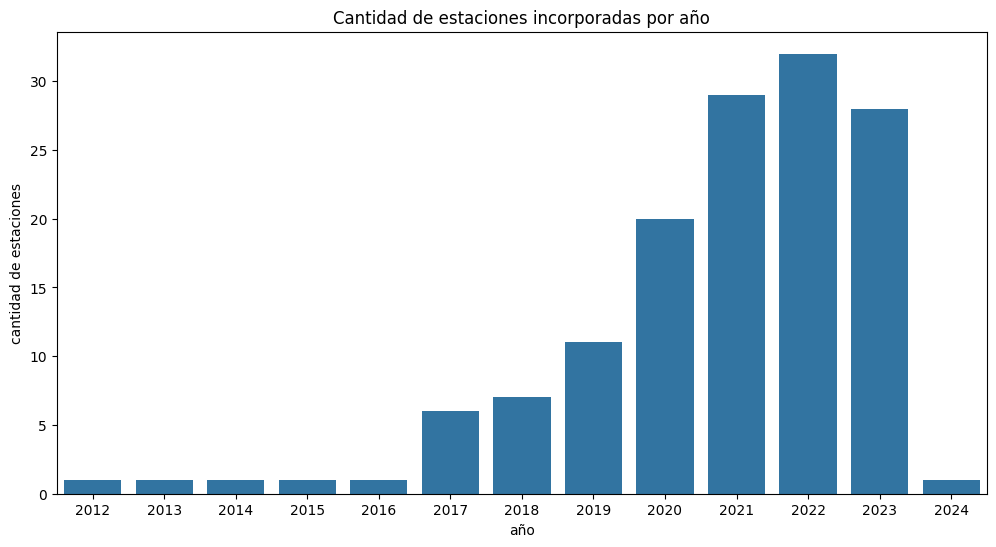

In [171]:
plt.figure(figsize=(12,6))
plt.title('Cantidad de estaciones incorporadas por año')
ax = sns.countplot(estaciones_elegidas,x=estaciones_elegidas['inicio'].dt.year)
plt.gca().set_xticklabels([año for año in range(2012,2025)])
plt.ylabel('cantidad de estaciones')
plt.xlabel('año')
plt.show()

In [168]:
plazo_dias = 365
dias_obs = estaciones_elegidas['dias_obs'] 
dias_obs_max = int(dias_obs.max())
lim_sup = ((dias_obs_max//plazo_dias)+1)*365+1
rangos_validos = [f"<{i+1}" for i,rango in enumerate(estaciones_elegidas['antiguedad_años'].unique())]
rangos_validos.pop(-1)
estaciones_elegidas['antiguedad_años'] = pd.cut(dias_obs,bins=range(0,lim_sup,plazo_dias),labels=rangos_validos)

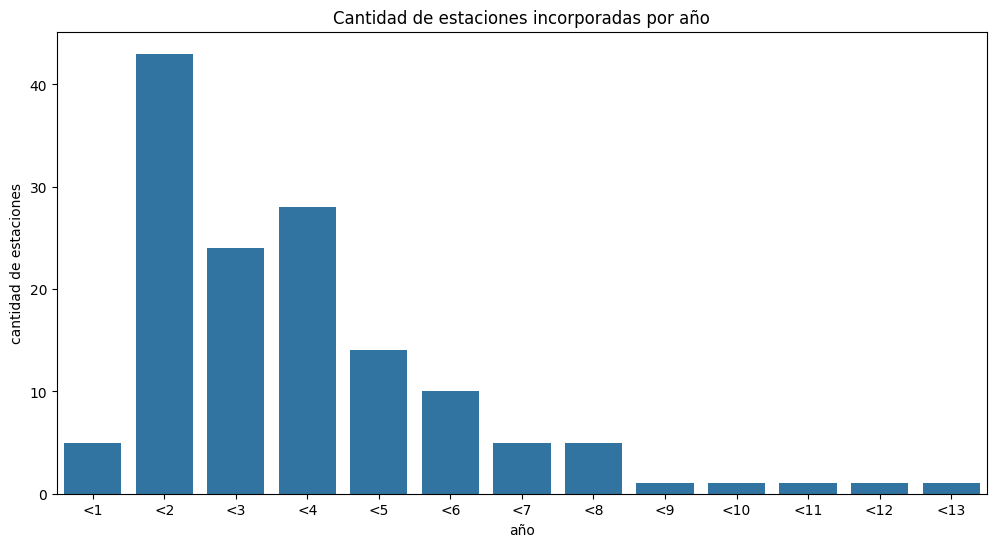

In [169]:
plt.figure(figsize=(12,6))
plt.title('Cantidad de estaciones incorporadas por año')
ax = sns.countplot(estaciones_elegidas,x='antiguedad_años')
plt.ylabel('cantidad de estaciones')
plt.xlabel('año')
plt.show()

### Análisis de rangos por columna

In [162]:
df_estacion[['humidityLow','humidityAvg','humidityHigh']]

,humidityLow,humidityAvg,humidityHigh
0,93.0,93.0,93.0
1,93.0,93.0,93.0
2,93.0,93.0,93.0
3,93.0,93.0,93.0
4,93.0,93.0,93.0
...,...,...,...
1113334,86.0,86.0,86.0
1113335,86.0,86.0,86.0
1113336,87.0,87.0,87.0
1113337,88.0,88.0,88.0


In [167]:
df_estacion[['dewptLow','dewptAvg','dewptHigh']]

,dewptLow,dewptAvg,dewptHigh
0,9.8,9.8,9.8
1,9.8,9.8,9.8
2,9.8,9.8,9.8
3,9.7,9.7,9.7
4,9.6,9.6,9.6
...,...,...,...
1113334,6.1,6.1,6.1
1113335,5.9,5.9,5.9
1113336,6.0,6.0,6.0
1113337,6.0,6.0,6.0


In [172]:
df_estacion[['heatindexLow','heatindexAvg','heatindexHigh']]

,heatindexLow,heatindexAvg,heatindexHigh
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,NaN,NaN,NaN
4,NaN,NaN,NaN
...,...,...,...
1113334,8.3,8.3,8.3
1113335,8.1,8.1,8.1
1113336,8.0,8.0,8.0
1113337,7.9,7.9,7.9


In [10]:
df_estacion[['pressureMin','pressureTrend','pressureMax']]

,pressureMin,pressureTrend,pressureMax
0,1013.21,0.0,1013.21
1,1013.21,0.0,1013.21
2,1013.21,0.0,1013.21
3,1013.21,0.0,1013.21
4,1013.55,0.0,1013.55
...,...,...,...
1113334,1026.75,NaN,1026.75
1113335,1026.41,NaN,1026.41
1113336,1026.41,NaN,1026.41
1113337,1026.41,NaN,1026.41


In [15]:
def min_max(df,variable):
    min=df[variable].min()
    max=df[variable].max()
    return min,max

In [141]:
variable='epoch'
min,max=min_max(df_estacion,'epoch')
print(variable,min,max)

epoch 1530414293.0 1564109756000.0


In [144]:
variable='solarRadiationHigh'
min,max=min_max(df_estacion,'solarRadiationHigh')
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

solarRadiationHigh 0.0 2206.0


array([  73.,   22., 1983.,  558.,  632.,  706.,  742.,  779.,  780.,
        743.,  705.,  411.,  155.,  192.,  412.,  668.,  888.,  777.,
        484.,  374.,  154.,  118.,   81.,   82.,   45.,   46.,  119.,
          9.,   10.,  266.,  522.,  778.,  521.,  301.,  228.,  229.,
        486., 1071., 1181.,  447.,  227.,  376.,  741.,  594.,    8.,
        191.,  448.,   80.,  117.,  153.,  190.,  373.,  446.,  556.,
        263.,  226.,  336.,  300.,  264.,  302.,  338.,  339.,  265.,
        375.,  704.,  667.,  156.,   83.,  449.,  485.,  193.,  669.,
        961., 1145., 1108.,  595.,   84.,  157.,  340.,  450.,  559.,
        120.,  303., 2130., 1876.,   44.,  740.,  850.,  887.,  922.,
        739.,  702.,  665.,  519.,  299.,  337.,  483.,  557.,  593.,
        886.,   40.,  114.,  150.,  224.,  260.,  297.,  371.,  407.,
        334.,  298.,  261.,  225.,  188.,  115.,   79.,   42.,    7.,
        410.,  631.,   43.,    0.,  230.,  267.,  413.,  520.,  630.,
        666.,  703.,

In [145]:
variable='uvHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

uvHigh 0.0 15.0


array([ 2., 11.,  0.,  1., 15.,  3.])

In [ ]:
variable='uvHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

In [146]:
variable='winddirAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

winddirAvg 0.0 359.0


array([  0.,  90., 180.,  45., 158., 338., 315., 135.,  22., 292., 270.,
       225., 248., 202., 112., 229., 249., 256., 267., 259., 245., 258.,
       232., 236., 227., 240., 291., 260., 247., 251., 272., 285., 296.,
       301., 207., 206., 243., 241., 238., 265., 244., 239., 254., 257.,
       234., 190., 165., 169., 192., 220., 255., 281.,  14.,   1.,  12.,
        10., 113., 203., 293.,  23.,  17.,  33.,  68., 341., 326.,   4.,
         6.,   2., 359., 324., 348., 349.,  46.,   7.,  11.,  38.,  30.,
        36., 329., 352.,  19., 344., 354.,  27., 353., 347., 340.,  24.,
       355.,  26.,  28., 356., 313., 271., 280., 288., 264., 269., 268.,
       237., 295., 125.,  87., 214., 118.,  34.,  54., 336., 331.,  20.,
       318., 152.,  79., 333., 110.,  75., 167., 343.,  32., 337., 325.,
        13.,  71., 201.,  21., 193., 147., 155.,  57., 358., 327.,  29.,
       294.,  98., 217., 213., 191., 266., 339.,  67., 274., 111., 101.,
       146.,  65.,  35., 143., 124., 116., 303., 19

In [149]:
variable='humidityHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

humidityHigh 0.0 99.0


array([93., 94., 95., 96., 97., 98., 99., 92., 91., 89., 88., 87., 86.,
       85., 84., 81., 80., 76., 75., 74., 73., 72., 70., 69., 67., 66.,
       63., 62., 61., 60., 58., 57., 56., 55., 54., 53., 52., 50., 51.,
       49., 48., 47., 45., 44., 43., 42., 41., 38., 37., 36., 35., 40.,
       39., 46., 65., 64., 59., 68., 71., 77., 78., 79., 82., 83., 34.,
       33., 32., 31., 90., 30., 29., 28., 27., 26., 25., 24., 23., 22.,
       21., 20., 19., 18., 17.,  0., 14.,  1.,  7., 16., 12., 15., 10.,
       11., 13.])

In [153]:
variable='qcStatus'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

qcStatus -1.0 1.0


array([-1.,  1.,  0.])

In [156]:
variable='tempAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

tempAvg -22.4 41.3


array([ 10.9,  10.8,  10.7,  10.4,  10.2,  10.3,  10.5,  10.6,  10.1,
        10. ,   9.9,   9.7,   9.5,   9.4,   9.3,   9.2,   9.1,   9. ,
         8.9,   8.8,   9.6,   8.7,   8.6,  11.1,  11.3,  11.5,  11.7,
        11.8,  12.1,  12.4,  12.7,  13. ,  13.4,  13.8,  14.2,  14.7,
        15. ,  15.2,  15.5,  15.7,  16. ,  16.2,  16.7,  16.9,  16.8,
        17.3,  17.6,  17.8,  18. ,  18.3,  18.5,  18.6,  18.8,  19. ,
        19.1,  19.2,  19.5,  19.6,  19.8,  19.9,  20.1,  20. ,  20.3,
        20.4,  20.6,  20.7,  21.1,  21. ,  21.2,  21.4,  21.5,  21.7,
        21.8,  21.9,  22. ,  22.3,  22.1,  22.2,  22.5,  22.8,  22.9,
        23. ,  22.7,  22.4,  21.6,  21.3,  20.9,  18.9,  18.4,  17.4,
        17.1,  16.6,  16.5,  16.4,  16.3,  16.1,  15.9,  15.8,  15.6,
        15.4,  14.8,  14.6,  14.5,  14.4,  14.3,  14.1,  14. ,  13.6,
        13.5,  13.7,  13.9,  13.3,  13.2,  12.8,  12.9,  13.1,  12.6,
        12.3,  12. ,  12.2,  11.9,  11. ,   9.8,  11.6,  12.5,  14.9,
        17.5,  19.3,

In [164]:
variable='windspeedHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windspeedHigh 0.0 490.4


array([  1.8,   0. ,   5.6,   3.7,   5. ,   7.4,   9.3,   6.1,  11.1,
        13. ,  14.8,  18.5,  16.7,  20.4,  22.2,  25.9,  24.1,  29.6,
         9.7,  13.4,  22. ,  27.8,  33.3,  28.2,  25.6,   4.8,  11.3,
        12.9,  14.5,   1.6,  16.1,   8. ,   8.7,  12.2,   7.2,  15.8,
         3.5,   2.6,   1.1,  18.3,  21.9,  23.3,  24.5,  20.8,  19.5,
        26.9,  30.6,  31.5,  25.4,  17.2,  34.3,   3.2,  20.9,  29.5,
        28. ,  34.1,  36.7,  33. ,  39.1,  40.2,  41.7,  35.6,  42.8,
        37.7,  45.2,  43.8,  48.9,  46.3,  47.8,  52.5,  60. ,  58.6,
        62.1,  63.6,  49.9,  51.3,  56. ,  55. ,  57.5,  68.2,  64.7,
        66.1,  53.9, 247.8, 111. ,  61. , 140. , 490.4,  46. ,  28.8,
        53.6,  19. ,  31.7,  27. ,  33.2,  40.4,  39.3,  37.8,  45.4,
        43.9,  46.5,  48. ,  51.5,  57.6,  52.6,  58.7,  50.1,  64.9,
        67.3,  60.2,  54.1,  61.2,  74.5,  62.3,  68.4,  66.3,  63.7,
        73.4,  69.8,  56.2,  71. ,  76. ,   5.8,  80.6,  85.6, 166.2,
       100.4, 296.6,

In [158]:
variable='windgustLow'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windgustLow 0.0 501.1


array([  0. ,   1.8,   5.6,   3.7,   5. ,   6.1,   7.4,   9.3,  11.1,
        13. ,  14.8,  18.5,  16.7,  20.4,  22.2,  25.9,  24.1,  29.6,
         9.7,  13.4,  22. ,  27.8,  33.3,  28.2,  25.6,  12.9,  11.3,
         4.8,   8. ,  17.7,  15.8,  12.2,  17.2,  18.3,  19.5,  20.8,
         8.7,   7.2,   3.5,   2.6,   1.1,  23.3,  25.4,  34.1,  28. ,
        29.5,  31.5,  33. ,  30.6,  24.5,  36.7,  40.2,  41.7,  39.1,
        21.9,  35.6,  26.9,  34.3,  20.9,   6.4,   3.2,   1.6,  19.3,
        16.1,  14.5,  37.7,  43.8,  45.2,  42.8,  46.3,  47.8,  49.9,
        48.9,  52.5,  55. ,  51.3,  56. ,  53.9,  58.6,  66.1,  74.4,
        67.1,  57.5,  72.3,  62.1,  60. ,  61. ,  63.6,  64.7,  70.8,
        69.7,  68.2,  80.5,  73.2,  79.3,  85.5, 249.6, 111. ,  78.4,
        81.9, 142.6,  76.9, 490.4, 131.2, 330.4, 501.1,  28.8, 146.9,
        53.6,  91.6, 226.6, 343.1, 311.1,  33.2,  31.7,  27. ,  40.4,
        37.8,  39.3,  54.1,  43.9,  45.4,  46.5,  48. ,  52.6,  50.1,
        51.5,  57.6,

In [169]:
variable='dewptHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

dewptHigh -28.0 37.7


array([  9.8,   9.7,   9.6,   9.3,   9.1,   9.4,   9.9,   9.5,   9.2,
         8.9,   9. ,   8.8,   8.7,   8.6,   8.4,   8.3,   8.5,  10.2,
        10.3,  10.4,  10.7,  10.9,  11.2,  11. ,  11.3,  10.8,  10.6,
        11.1,  10.5,   8.1,   7.3,   7.1,   7.2,   6.9,   6.4,   7.4,
         6.6,   6.7,   7. ,   7.5,   7.9,   7.6,   8.2,   8. ,   7.8,
        10. ,  10.1,   6.8,   6.5,   7.7,   5.8,   5.4,   5.2,   5.9,
         6. ,   4.9,   5.3,   5.6,   4.8,   4.3,   4.4,   5.1,   4.6,
         3.9,   3.5,   3.6,   3.7,   4. ,   4.1,   4.2,   3.8,   4.7,
         4.5,   5. ,   5.7,   3.4,   3.2,   3.3,   3.1,   3. ,   2.7,
         2.9,   2.8,   2.6,   1.6,   1.8,   1.9,   2.3,   6.1,   6.2,
         6.3,   2.4,   2.2,   2.1,   1.7,   2. ,   1.5,   1.4,   2.5,
         1.1,   0.9,   0.7,   0.6,   0.8,   1. ,   0.5,   0.4,   0.3,
         1.2,   0.2,   0.1,  -0.3,  -0.6,  -0.7,  -0.8,  -1.1,  -1.2,
        -1.3,  -1.4,  -1.6,  -1.9,  -2. ,  -2.1,  -1.8,  -1.7,  -2.4,
        -2.5,  -2.2,

In [170]:
variable='windchillHigh'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

windchillHigh -31.0 41.3


array([ 26.3,  25.8,  25.5,  25.2,  25.1,  25. ,  24.9,  24.7,  24.6,
        24.4,  24.3,  24.1,  23.9,  23.8,  23.5,  23.3,  23.2,  23.1,
        22.8,  22.4,  22.3,  22.2,  22.1,  22. ,  21.8,  21.4,  21.3,
        20.9,  21.2,  21. ,  21.9,  21.5,  21.7,  21.6,  21.1,  20.3,
        19.3,  18.8,  18.9,  18.3,  18.2,  18.1,  17.3,  17.7,  17.6,
        17. ,  16.6,  16.5,  16.3,  16.8,  16.4,  16.1,  15.7,  15.9,
        15.8,  15.5,  15.6,  15.2,  15.4,  15.3,  15. ,  15.1,  14.8,
        14.7,  14.6,  14.4,  14.2,  14.5,  14.1,  14.3,  14. ,  13.9,
        13.5,  13.4,  13.3,  13.2,  13.6,  12.8,  12.9,  13.1,  12.7,
        12.6,  12.2,  11.9,  12. ,  12.4,  11.5,  11.4,  11.2,  11.1,
        11.8,  11.3,  11.7,  10.8,  10.9,  10.7,  10.4,  10.3,  10.2,
        10. ,  10.1,   9.9,   9.8,   9.3,   9.4,   9.2,   9.6,   9.5,
        10.6,  12.1,  11. ,   9.7,   8.1,   7.1,   4.8,   6.7,   7.8,
         7.6,   7.7,   8.6,   8.8,   8.7,   9.1,   9. ,  10.5,   8.9,
         8.4,   8.3,

In [173]:
variable='heatindexAvg'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

heatindexAvg -22.4 91.6


array([ 25.6,  25.5,  25.4,  25.3,  25.2,  25.1,  25. ,  24.9,  24.6,
        24.5,  24.4,  23.9,  23.8,  24. ,  24.1,  24.3,  24.8,  24.7,
        24.2,  25.8,  26. ,  26.1,  25.7,  26.2,  26.4,  26.6,  26.8,
        26.9,  27.1,  27.3,  27.9,  28.1,  28.7,  28.8,  30. ,  30.2,
        29.9,  30.4,  30.6,  30.5,  30.7,  31.2,  31.4,  31.6,  31.7,
        31.8,  32.1,  32.3,  31.9,  32.7,  32.9,  33. ,  33.2,  33.3,
        33.1,  32.8,  32.6,  32.5,  32. ,  32.2,  30.9,  31.1,  31.3,
        33.4,  33.5,  33.7,  33.8,  40.2,  42.2,  37.4,  36.2,  35.4,
        35.2,  34.9,  34.8,  34.2,  34.1,  30.8,  29.6,  29.3,  28.6,
        28.5,  28.2,  27.8,  29.7,  26.7,  27.2,  27.4,  27.5,  26.5,
        27.6,  27.7,  28.9,  29. ,  28.4,  29.2,  29.4,  29.8,  33.6,
        34. ,  34.3,  34.4,  35.1,  35.5,  35.7,  36. ,  36.4,  36.7,
        36.9,  37. ,  37.9,  38.5,  39.2,  39.8,  40. ,  40.1,  40.5,
        41. ,  41.6,  42.7,  43.1,  43.3,  42.1,  41.8,  41.4,  42. ,
        41.3,  41.9,

In [7]:
variable='pressureMax'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

pressureMax 852.69 1323.4


array([1013.21, 1013.55, 1012.87, 1012.53, 1012.19, 1011.85, 1011.51,
       1011.18, 1010.84, 1010.5 , 1010.16, 1009.82, 1009.48, 1009.14,
       1008.81, 1008.47, 1008.13, 1007.79, 1007.45, 1007.11, 1006.77,
       1006.43, 1006.1 , 1005.76, 1005.42, 1005.08, 1004.74, 1004.4 ,
       1004.06, 1003.73, 1003.39, 1003.05, 1002.71, 1002.37, 1002.03,
       1001.69, 1001.36, 1001.02, 1000.68, 1000.34, 1000.  ,  999.66,
        999.32,  998.98, 1015.92, 1019.3 ,  995.6 ,  992.21,  998.65,
        998.31,  997.97,  997.63,  997.29, 1013.88, 1014.22, 1014.56,
       1014.9 , 1015.24, 1015.58, 1016.26, 1016.59, 1016.93, 1017.27,
       1017.61, 1017.95, 1018.29, 1018.63, 1018.96, 1019.64, 1019.98,
       1020.32, 1020.66, 1021.  , 1021.33, 1021.67, 1022.01, 1022.35,
       1022.69, 1023.03, 1023.37, 1023.71, 1024.04, 1024.38, 1024.72,
       1025.06, 1025.4 , 1025.74, 1026.08, 1026.41, 1026.75,  996.95,
        996.61,  996.28,  995.94,  995.26,  994.92,  994.58,  994.24,
        993.91,  993

In [11]:
variable='pressureTrend'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

pressureTrend -2314.64 21.62


array([ 0.00000e+00, -1.02000e+00, -6.80000e-01, -3.40000e-01,
        3.40000e-01,  2.37000e+00,  2.71000e+00,  3.05000e+00,
       -3.39000e+00, -3.05000e+00, -2.71000e+00, -2.37000e+00,
       -2.03000e+00, -1.69000e+00, -1.35000e+00,  4.40000e+00,
        6.80000e-01,  1.02000e+00,  4.12000e+00, -4.32000e+00,
        4.32000e+00, -4.82000e+00, -4.12000e+00, -4.34000e+00,
       -4.10000e+00, -5.42000e+00,  4.10000e+00,  4.34000e+00,
        4.82000e+00, -5.39000e+00,  5.39000e+00, -7.87000e+00,
        4.31000e+00, -4.55000e+00,  4.55000e+00,  4.57000e+00,
       -4.57000e+00,  5.78000e+00,  8.65000e+00,  5.42000e+00,
        5.75000e+00, -4.31000e+00,  7.17000e+00, -4.25000e+00,
       -4.80000e+00,  8.24000e+00, -8.24000e+00, -9.60000e+00,
       -5.75000e+00, -8.65000e+00,  8.68000e+00,  5.08000e+00,
       -6.19000e+00,  7.87000e+00,  1.71700e+01, -5.08000e+00,
        6.63000e+00, -6.16000e+00,  4.13000e+00, -4.53000e+00,
        6.19000e+00, -5.10000e+00, -5.78000e+00,  4.800

In [14]:
variable='precipRate'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

precipRate 0.0 4915.15


array([0.00000e+00, 5.10000e-01, 2.54000e+00, 2.03000e+00, 2.79000e+00,
       1.01600e+01, 2.50000e-01, 1.02000e+00, 1.27000e+00, 1.52000e+00,
       1.78000e+00, 2.29000e+00, 3.05000e+00, 3.56000e+00, 4.32000e+00,
       4.83000e+00, 5.08000e+00, 5.33000e+00, 3.81000e+00, 6.10000e+00,
       6.35000e+00, 3.30000e+00, 4.57000e+00, 5.59000e+00, 7.87000e+00,
       8.64000e+00, 2.53975e+03, 7.11000e+00, 8.38000e+00, 8.13000e+00,
       9.40000e+00, 6.86000e+00, 7.37000e+00, 8.89000e+00, 6.60000e+00,
       1.09200e+01, 1.21900e+01, 1.32100e+01, 1.34600e+01, 1.42200e+01,
       1.95600e+01, 2.69200e+01, 3.02300e+01, 3.20000e+01, 1.14300e+01,
       1.11800e+01, 1.52400e+01, 1.67600e+01, 9.65000e+00, 1.04100e+01,
       1.19400e+01, 1.93000e+01, 2.36200e+01, 2.74300e+01, 2.94600e+01,
       2.97200e+01, 9.91000e+00, 1.77800e+01, 1.80300e+01, 1.16800e+01,
       1.62600e+01, 1.82900e+01, 1.44800e+01, 1.47300e+01, 1.49900e+01,
       2.28600e+01, 2.81900e+01, 3.07300e+01, 3.17500e+01, 3.480

In [16]:
variable='precipTotal'
min,max=min_max(df_estacion,variable)
print(variable,min,max)
df_estacion[variable][~df_estacion[variable].isna()].unique()

precipTotal 0.0 2539.75


array([0.00000e+00, 5.10000e-01, 2.03000e+00, 2.79000e+00, 1.27000e+00,
       1.78000e+00, 2.50000e-01, 1.02000e+00, 1.52000e+00, 2.29000e+00,
       3.05000e+00, 3.30000e+00, 3.56000e+00, 4.32000e+00, 4.83000e+00,
       5.33000e+00, 6.10000e+00, 6.60000e+00, 6.86000e+00, 7.11000e+00,
       8.38000e+00, 9.65000e+00, 9.91000e+00, 1.01600e+01, 1.04100e+01,
       1.19400e+01, 1.42200e+01, 1.47300e+01, 1.49900e+01, 1.52400e+01,
       1.54900e+01, 1.62600e+01, 1.65100e+01, 1.67600e+01, 1.70200e+01,
       1.75300e+01, 1.77800e+01, 1.80300e+01, 1.82900e+01, 1.88000e+01,
       1.95600e+01, 1.98100e+01, 2.00700e+01, 2.03200e+01, 2.05700e+01,
       2.10800e+01, 2.13400e+01, 2.15900e+01, 2.18400e+01, 2.21000e+01,
       2.26100e+01, 2.28600e+01, 3.81000e+00, 5.08000e+00, 6.35000e+00,
       7.87000e+00, 9.40000e+00, 1.09200e+01, 1.11800e+01, 1.14300e+01,
       1.16800e+01, 1.21900e+01, 1.27000e+01, 1.29500e+01, 1.32100e+01,
       1.34600e+01, 1.37200e+01, 1.44800e+01, 1.85400e+01, 1.930

## ORM

### Wunder

Motores

In [14]:
# Conexión con SQL SERVER
""" connection_string = "DRIVER=ODBC Driver 17 for SQL Server;SERVER=localhost;DATABASE=estaciones_wunder;trusted_connection=yes"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url) """

' connection_string = "DRIVER=ODBC Driver 17 for SQL Server;SERVER=localhost;DATABASE=estaciones_wunder;trusted_connection=yes"\nconnection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})\nengine = create_engine(connection_url) '

In [60]:
# Conexión con MySQL
engine = create_engine("mysql+mysqlconnector://root:@localhost:3306/estaciones_wunder")
# Test the connection
connection = engine.connect()


Tablas

In [61]:
class Base(DeclarativeBase):
    pass

In [62]:
class Estacion(Base):
     __tablename__ = "estaciones"
     __table_args__ = {'extend_existing': True}
     
     id_estacion: Mapped[int] = mapped_column(primary_key=True)
     stationID: Mapped[str] = mapped_column(String(20),unique=True)
     #En los siguientes 3 atributos se permite nulo porque hay estaciones sin observaciones
     tz: Mapped[str] = mapped_column(String(50),nullable=True)
     lat: Mapped[float] = mapped_column(Float(),nullable=True)
     lon: Mapped[float] = mapped_column(Float(),nullable=True)
     inicio: Mapped[str] = mapped_column(DateTime(),nullable=True)
     comentario: Mapped[str] = mapped_column(String(50),nullable=True)
     #activa: Mapped[bool] = mapped_column(Boolean(),default=1)
     observaciones: Mapped[List["Observacion"]] = relationship(back_populates="estacion")

     def __repr__(self) -> str:
         return f"stationID={self.stationID!r}"

In [63]:
class Observacion(Base):
    __tablename__ = "observaciones"
    # Defino la restricción para evitar registros que compartan el id de la estación y la fecha (reportes duplicados)
    __table_args__ = (UniqueConstraint('id_estacion','obsTimeLocal'),{'extend_existing': True})

    id_observacion: Mapped[int] = mapped_column(primary_key=True)
    id_estacion: Mapped[int] = mapped_column(ForeignKey("estaciones.id_estacion"))
    obsTimeLocal: Mapped[str] = mapped_column(DateTime())
    solarRadiationHigh_watts_m2: Mapped[float] = mapped_column(Float(),nullable=True)
    uvHigh_indice: Mapped[float] = mapped_column(Float(),nullable=True)
    winddirAvg_grado: Mapped[float] = mapped_column(SmallInteger(),nullable=True)
    humidityHigh_porcentaje : Mapped[float] = mapped_column(SmallInteger(),nullable=True) #Llevar a tinyint
    humidityLow_porcentaje : Mapped[float] = mapped_column(SmallInteger(),nullable=True) #Llevar a tinyint
    humidityAvg_porcentaje : Mapped[float] = mapped_column(SmallInteger(),nullable=True) #Llevar a tinyint
    tempHigh_grados_C : Mapped[float] = mapped_column(Float(),nullable=True) 
    tempLow_grados_C : Mapped[float] = mapped_column(Float(),nullable=True) 
    tempAvg_grados_C : Mapped[float] = mapped_column(Float(),nullable=True) 
    windspeedHigh_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    windspeedLow_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    windspeedAvg_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    windgustHigh_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    windgustLow_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    windgustAvg_km_h : Mapped[float] = mapped_column(Float(),nullable=True)
    dewptHigh_grados_C : Mapped[float] = mapped_column(Float(),nullable=True)
    dewptLow_grados_C : Mapped[float] = mapped_column(Float(),nullable=True)
    dewptAvg_grados_C : Mapped[float] = mapped_column(Float(),nullable=True)
    windchillHigh_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    windchillLow_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    windchillAvg_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    heatindexHigh_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    heatindexLow_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    heatindexAvg_indefinda : Mapped[float] = mapped_column(Float(),nullable=True)
    pressureMax_hPa : Mapped[float] = mapped_column(Float(),nullable=True)
    pressureMin_hPa : Mapped[float] = mapped_column(Float(),nullable=True)
    pressureTrend_hPa : Mapped[float] = mapped_column(Float(),nullable=True)
    precipRate_mm : Mapped[float] = mapped_column(Float(),nullable=True)
    precipTotal_mm : Mapped[float] = mapped_column(Float(),nullable=True)
    dia_con_obs: Mapped[bool] = mapped_column(Boolean())
    #dia_completo: Mapped[bool] = mapped_column(Boolean())
    estacion: Mapped[Estacion] = relationship(back_populates="observaciones")

    def __repr__(self) -> str:
         return f"id_estacion={self.id_estacion!r}, obsTimeLocal={self.obsTimeLocal!r}"

In [65]:
Base.metadata.create_all(engine)

In [64]:
Observacion.__table__.drop(engine)
Estacion.__table__.drop(engine)

CRUD ESTACIONES

In [67]:
def obtener_datos_utiles_estaciones(info_estaciones:pd.DataFrame)->dict:
    """ Construye un diccionario con los metadatos de las estaciones """
    info_util_estaciones = []
    for i,estacion in info_estaciones.iterrows():
        info_util_estacion = {}
        info_util_estacion['stationID'] = estacion['stationID']
        info_util_estacion['lat'] = estacion['lat']
        info_util_estacion['lon'] = estacion['lon']
        info_util_estacion['tz'] = estacion['tz']
        info_util_estacion['inicio'] = str(estacion['inicio'])
        info_util_estacion['comentario'] = estacion['comentario']
        info_util_estaciones.append(info_util_estacion)
    return info_util_estaciones    

In [ ]:
def insertar_estaciones(estaciones:list[dict])->None:
    with Session(engine) as session:
        for estacion in estaciones:
            #Creo el objeto de la clase estación. 
            # Tengo que imputar None a los faltantes para no tener problemas luego en la inserción de las estaciones.
            # Tipos de faltantes. np.nan | np.float(nan) | pandas._libs.tslibs.nattype.NaTType -> dan errores en la inserción
            obj_estacion = Estacion(
                stationID= estacion['stationID'],
                tz= estacion['tz'] if estacion['comentario'] != 'sin observaciones' else None,
                lat= float(estacion['lat']) if estacion['comentario'] != 'sin observaciones' else None,
                lon= float(estacion['lon']) if estacion['comentario'] != 'sin observaciones' else None,
                inicio= estacion['inicio'] if estacion['comentario'] != 'sin observaciones' else None,
                comentario= None if estacion['comentario'] != 'sin observaciones' else estacion['comentario'],
            )
            print(obj_estacion)
            session.add(obj_estacion) 
        session.commit()

In [69]:
estaciones_meta_datos =obtener_datos_utiles_estaciones(estaciones_elegidas)

In [70]:
insertar_estaciones(estaciones_meta_datos)

stationID='IROCUA51'
stationID='ISANTA538'
stationID='IROSAR86'
stationID='IJOVIT1'
stationID='ISANJA13'
stationID='ICONSTIT3'
stationID='IMELIN1'
stationID='IROSEG16'
stationID='ISANLO49'
stationID='IGENER305'
stationID='IARMST25'
stationID='IROSAR68'
stationID='IDEPAR77'
stationID='IROCUA44'
stationID='IROSAR103'
stationID='ILOSMO6'
stationID='IGENER220'
stationID='IJUREZ17'
stationID='IROSAR70'
stationID='IMARCO44'
stationID='IPERGA21'
stationID='IROCUA49'
stationID='IUNINDEP8'
stationID='IGENER186'
stationID='IROSAR30'
stationID='ISANTAFE23'
stationID='IARIAS1'
stationID='IAMENB2'
stationID='IADELI1'
stationID='IBELGR31'
stationID='ICAADA3'
stationID='ICALAM23'
stationID='ICAADA2'
stationID='IBUSTI3'
stationID='IBIGAN11'
stationID='ICASER40'
stationID='ICASER25'
stationID='ICORDOBA23'
stationID='ICASER21'
stationID='ICALAM32'
stationID='ICASER34'
stationID='ICASER12'
stationID='ICONSTIT2'
stationID='ICASIL2'
stationID='ICONST54'
stationID='ICONSTIT4'
stationID='ICOLN10'
stationID='

CRUD OBSERVACIONES

In [ ]:
""" var_sin_unidad=['stationID',"tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
var_con_unidad=["tempHigh","tempLow","tempAvg","windspeedHigh","windspeedLow","windspeedAvg","windgustHigh","windgustLow","windgustAvg","dewptHigh","dewptLow","dewptAvg","windchillHigh","windchillLow","windchillAvg","heatindexHigh","heatindexLow","heatindexAvg","pressureMax","pressureMin","pressureTrend","precipRate","precipTotal"]
var_wunder=var_sin_unidad+var_con_unidad """

In [31]:
def ORM_extraer_campos(estacion:Estacion,observaciones:list,dia:date,stationId:str)->list:
    """agrega observaciones al objeto estación"""
    if (len(observaciones)==0):
        obs = Observacion(
                obsTimeLocal=str(dia),
                dia_con_obs= 0,
        )
        estacion.observaciones.append(obs)
    else:
        for observacion in observaciones:
            obs = Observacion(
                obsTimeLocal=observacion['obsTimeLocal'],
                solarRadiationHigh_watts_m2= observacion['solarRadiationHigh'],
                uvHigh_indice= observacion['uvHigh'],
                winddirAvg_grado = observacion['winddirAvg'],
                humidityHigh_porcentaje = observacion['humidityHigh'],
                humidityLow_porcentaje = observacion['humidityLow'],
                humidityAvg_porcentaje = observacion['humidityAvg'],
                tempHigh_grados_C = observacion['metric']['tempHigh'],
                tempLow_grados_C = observacion['metric']['tempLow'],
                tempAvg_grados_C = observacion['metric']['tempAvg'],
                windspeedHigh_km_h = observacion['metric']['windspeedHigh'],
                windspeedLow_km_h = observacion['metric']['windspeedLow'],
                windspeedAvg_km_h = observacion['metric']['windspeedAvg'],
                windgustHigh_km_h = observacion['metric']['windgustHigh'],
                windgustLow_km_h = observacion['metric']['windgustLow'],
                windgustAvg_km_h = observacion['metric']['windgustAvg'],
                dewptHigh_grados_C = observacion['metric']['dewptHigh'],
                dewptLow_grados_C = observacion['metric']['dewptLow'],
                dewptAvg_grados_C = observacion['metric']['dewptAvg'],
                windchillHigh_indefinda = observacion['metric']['windchillHigh'],
                windchillLow_indefinda = observacion['metric']['windchillLow'],
                windchillAvg_indefinda = observacion['metric']['windchillAvg'],
                heatindexHigh_indefinda = observacion['metric']['heatindexHigh'],
                heatindexLow_indefinda = observacion['metric']['heatindexLow'],
                heatindexAvg_indefinda = observacion['metric']['heatindexAvg'],
                pressureMax_hPa = observacion['metric']['pressureMax'],
                pressureMin_hPa = observacion['metric']['pressureMin'],
                pressureTrend_hPa = observacion['metric']['pressureTrend'],
                precipRate_mm = observacion['metric']['precipRate'],
                precipTotal_mm = observacion['metric']['precipTotal'],
                dia_con_obs= 1,
            )
            estacion.observaciones.append(obs)

In [28]:
estaciones_elegidas['fecha_ultimo_reporte']

0     2024-09-11 00:00:00
1     2024-09-11 00:00:00
2     2024-02-22 21:39:42
3     2024-04-25 23:59:47
4     2024-09-11 00:00:00
              ...        
138   2024-09-11 00:00:00
139   2024-09-11 00:00:00
140   2024-09-11 00:00:00
141   2024-09-11 00:00:00
142   2024-09-11 00:00:00
Name: fecha_ultimo_reporte, Length: 143, dtype: datetime64[ns]

In [34]:
def insertar_reportes_dia(fecha:date,claves_api:list[str])->None:
    numero_llamada_global=0
    numero_llamada_api_key=0
    #Seteo de variables
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    with Session(engine) as session:
        estaciones = session.query(Estacion).all()
        for estacion_obj in estaciones:
            estacion_id=estacion_obj.stationID
            if (numero_llamada_api_key==1400):
                    imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                    api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                    #Si se agotaron las api keys se rompe el bucle white
                    if (api_key==''):
                        break  
                    numero_llamada_api_key=0
            fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
            recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
            # Se sale del bluce si se pudo realizar la llamada a la estacion o si se agotaron las api keys 
            while True:
                try:
                    # Mandatoriamente se debe indicar un tiempo límite de espera para evitar que la llamada quede inconclusa por falta de respuesta de la API
                    respuesta = requests.get(recurso,timeout=60,headers={'Cache-Control': 'no-cache'})
                    codigo_respusta=respuesta.status_code
                    numero_llamada_api_key+=1
                    numero_llamada_global+=1
                    # Status Code 200: OK. The request has succeeded.
                    # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
                    if (codigo_respusta==200 or codigo_respusta==204):
                        observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else [] 
                        #total_observaciones+=ORM_extraer_campos(IPREZ1,observaciones_un_dia,fecha,estacion_id,var_w)
                        ORM_extraer_campos(estacion=estacion_obj,observaciones=observaciones_un_dia,dia=fecha,stationId=estacion_id)
                        break
                    elif (codigo_respusta==401):
                        # Status Code 401: Unauthorized. The request requires authentication.
                        imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0      
                    elif (codigo_respusta==500):
                        imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                        una_hora=60*60
                        #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                        time.sleep(una_hora)
                    else:
                        imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
                        una_hora=60*60
                        time.sleep(una_hora)
                except requests.exceptions.RequestException as error:
                    numero_error_conexion+=1
                    imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error) 
                    un_minuto=60
                    #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                    time.sleep(un_minuto)   
            #Sale del while y corroborra que se pueda pasar a la siguiente estación 
            if (api_key==''):    
                imprimir_mensaje(situacion='sin api keys',url=recurso)
                break
            
            imprimir_mensaje(situacion='cambio estacion',identificador_estacion=estacion_id)
        session.commit()  
                
    imprimir_mensaje(situacion='fin ejecución',llamadas_totales=numero_llamada_global)  

In [35]:
fecha_elegida = date(2024,9,12)
insertar_reportes_dia(fecha=fecha_elegida,claves_api=api_keys)

se cargaron todas las observacines de IADELI1
se cargaron todas las observacines de IAMENB2
se cargaron todas las observacines de IARIAS1
se cargaron todas las observacines de IARMST25
se cargaron todas las observacines de IBELGR31
se cargaron todas las observacines de IBIGAN11
se cargaron todas las observacines de IBUSTI3
se cargaron todas las observacines de ICAADA2
se cargaron todas las observacines de ICAADA3
se cargaron todas las observacines de ICALAM23
se cargaron todas las observacines de ICALAM32
se cargaron todas las observacines de ICASER12
se cargaron todas las observacines de ICASER21
se cargaron todas las observacines de ICASER25
se cargaron todas las observacines de ICASER34
se cargaron todas las observacines de ICASER40
se cargaron todas las observacines de ICASER42
se cargaron todas las observacines de ICASIL2
se cargaron todas las observacines de ICOLN10
se cargaron todas las observacines de ICONST54
se cargaron todas las observacines de ICONSTIT2
se cargaron todas la

In [37]:
def completar_reportes(claves_api:list[str])->None:
    numero_llamada_global=0
    numero_llamada_api_key=0
    #Seteo de variables
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    fecha_actual = datetime.now().date()
    with Session(engine) as session:
        estaciones = session.query(Estacion).all()
        for estacion_obj in estaciones:
            estacion_id=estacion_obj.stationID
            ultima_fecha_DB = estacion_obj.observaciones[-1].obsTimeLocal
            fecha = ultima_fecha_DB.date() + timedelta(days=1)
            while fecha<=fecha_actual:
                if (numero_llamada_api_key==1400):
                        imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0
                fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
                if (fecha==fecha_actual):
                    recurso=f'https://api.weather.com/v2/pws/observations/all/1day?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal'
                else:
                    recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
                try:
                    # Mandatoriamente se debe indicar un tiempo límite de espera para evitar que la llamada quede inconclusa por falta de respuesta de la API
                    respuesta = requests.get(recurso,timeout=60,headers={'Cache-Control': 'cache-control: max-age=599'})
                    codigo_respusta=respuesta.status_code
                    numero_llamada_api_key+=1
                    numero_llamada_global+=1
                    # Status Code 200: OK. The request has succeeded.
                    # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
                    if (codigo_respusta==200 or codigo_respusta==204):
                        observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else [] 
                        #total_observaciones+=ORM_extraer_campos(IPREZ1,observaciones_un_dia,fecha,estacion_id,var_w)
                        ORM_extraer_campos(estacion=estacion_obj,observaciones=observaciones_un_dia,dia=fecha,stationId=estacion_id)
                        fecha+= timedelta(days=1)
                    elif (codigo_respusta==401):
                        # Status Code 401: Unauthorized. The request requires authentication.
                        imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0      
                    elif (codigo_respusta==500):
                        imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                        una_hora=60*60
                        #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                        time.sleep(una_hora)
                    else:
                        imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
                except requests.exceptions.RequestException as error:
                    numero_error_conexion+=1
                    imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error) 
                    un_minuto=60
                    #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                    time.sleep(un_minuto)   
            #Sale del while y corroborra que se pueda pasar a la siguiente estación 
            if (api_key==''):    
                imprimir_mensaje(situacion='sin api keys',url=recurso)
                break
            else:
                imprimir_mensaje(situacion='cambio estacion',identificador_estacion=estacion_id)
        # Guarda todas las observaciones extraídas, aún cuando el script no haya realizado todas las consultas que correspondían
        imprimir_mensaje(situacion='fin ejecución',llamadas_totales=numero_llamada_global)  
        session.commit()  

In [21]:
def eliminar_ultimos_reportes():
    """Para cada estación elimina las observaciones del último día con reportes"""
    with Session(engine) as session:
        estaciones = session.query(Estacion).all()
        for estacion in estaciones:
            observaciones = estacion.observaciones
            ultima_observacion = observaciones[-1]
            ultima_fecha = ultima_observacion.obsTimeLocal
            ultimo_año = ultima_fecha.year
            ultimo_mes = ultima_fecha.month
            ultimo_dia = ultima_fecha.day
            for obs in observaciones:
                obs_fecha = obs.obsTimeLocal
                obs_año = obs_fecha.year
                obs_mes = obs_fecha.month
                obs_dia = obs_fecha.day
                if (ultimo_año == obs_año and ultimo_mes == obs_mes and ultimo_dia == obs_dia):
                    session.delete(obs)
        session.commit()  
            
    

In [38]:
completar_reportes(claves_api=api_keys)

se cargaron todas las observacines de IADELI1
se cargaron todas las observacines de IAMENB2
se cargaron todas las observacines de IARIAS1
se cargaron todas las observacines de IARMST25
se cargaron todas las observacines de IBELGR31
Hubo un problema con la conexión al servidor.
Error número:1.
Error:Expecting value: line 1 column 1 (char 0)
Se aguarda 1 minuto
se cargaron todas las observacines de IBIGAN11
se cargaron todas las observacines de IBUSTI3
se cargaron todas las observacines de ICAADA2
se cargaron todas las observacines de ICAADA3
se cargaron todas las observacines de ICALAM23
se cargaron todas las observacines de ICALAM32
se cargaron todas las observacines de ICASER12
se cargaron todas las observacines de ICASER21
se cargaron todas las observacines de ICASER25
se cargaron todas las observacines de ICASER34
se cargaron todas las observacines de ICASER40
se cargaron todas las observacines de ICASER42
se cargaron todas las observacines de ICASIL2
se cargaron todas las observaci

SUPLEMENTO

In [148]:
def insertarObservacionesBD(estacion):
    session = Session(engine)
    session.add(estacion)
    session.flush()
    session.commit()
    session.close()

In [ ]:
def ORM_datos_estaciones(estaciones:pd.DataFrame,claves_api:list[str])->None:
    numero_llamada_global=0
    numero_llamada_api_key=0
    #Seteo de variables
    api_key=claves_api[0]
    numero_error_conexion=0
    recurso=''
    for i,estacion in estaciones.iterrows():
        if estacion['buscar_obs'] == 1:
            IPREZ1 = Estacion(stationID='IPREZ1',lat=-32.997496,lon=-60.768009)
            print('observaciones IPREZ1',IPREZ1.observaciones)
            estacion_id=estacion['id']
            fecha = estacion['inicio']
            año = fecha.year
            mes = fecha.month
            dia = fecha.day
            #total_observaciones=[]  
            fecha=date(año,mes,dia)
            fecha_limite = date(2024,1,31)
            while fecha<=fecha_limite:
                if (numero_llamada_api_key==1400):
                        imprimir_mensaje(situacion='llamada 1400',vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0
                fecha_str = "{:04d}".format(fecha.year) + "{:02d}".format(fecha.month) + "{:02d}".format(fecha.day)
                recurso=f'https://api.weather.com/v2/pws/history/all?stationId={estacion_id}&format=json&units=m&apiKey={api_key}&numericPrecision=decimal&date={fecha_str}'
                try:
                    # Mandatoriamente se debe indicar un tiempo límite de espera para evitar que la llamada quede inconclusa por falta de respuesta de la API
                    respuesta = requests.get(recurso,timeout=60)
                    codigo_respusta=respuesta.status_code
                    numero_llamada_api_key+=1
                    numero_llamada_global+=1
                    # Status Code 200: OK. The request has succeeded.
                    # Status Code 204: No Data Found for specific query. The 204 status code will have an empty response body.
                    if (codigo_respusta==200 or codigo_respusta==204):
                        observaciones_un_dia = respuesta.json()['observations'] if codigo_respusta==200 else [] 
                        #total_observaciones+=ORM_extraer_campos(IPREZ1,observaciones_un_dia,fecha,estacion_id)
                        ORM_extraer_campos(IPREZ1,observaciones_un_dia,fecha,estacion_id)
                        fecha+= timedelta(days=1)
                    elif (codigo_respusta==401):
                        # Status Code 401: Unauthorized. The request requires authentication.
                        imprimir_mensaje(situacion='api key desautorizada',status_code=codigo_respusta,vieja_api_key=api_key)
                        api_key=cambiar_api_key(conjunto_api_key=api_keys,api_key_actual=api_key)
                        #Si se agotaron las api keys se rompe el bucle white
                        if (api_key==''):
                            break  
                        numero_llamada_api_key=0      
                    elif (codigo_respusta==500):
                        imprimir_mensaje(situacion='el servidor no contesta',status_code=codigo_respusta)
                        una_hora=60*60
                        #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                        time.sleep(una_hora)
                    else:
                        imprimir_mensaje(situacion='respesta del servidor desconocida',status_code=codigo_respusta,url=recurso)    
                except requests.exceptions.RequestException as error:
                    numero_error_conexion+=1
                    imprimir_mensaje(situacion='error de conexión',n_error_con=numero_error_conexion,problema=error) 
                    un_minuto=60
                    #Se pausa la ejecución para aguardar que normalicen el funcionamiento del servidor 
                    time.sleep(un_minuto)   
            #Escribe todas las observaciones recolectadas de la estación antes de saltar a la siguiente
            ubicacion=f'C:/Users/Usuario/Documents/observaciones/completas/observaciones_completas_{estacion_id}.csv'
            var_con=["dia_con_obs","dia_completo"]
            var_todas=tuple(var_w+var_con)
            imprimir_mensaje(situacion='cambio estacion',identificador_estacion=estacion_id)
            print('observaciones IPREZ1',IPREZ1.observaciones)
            #escribirCSV(ruta=ubicacion,datos=total_observaciones,campos_encabezado=var_todas)
            insertarObservacionesBD(IPREZ1)

        #Sale del while y corroborra que se pueda pasar a la siguiente estación 
        if (api_key==''):    
            imprimir_mensaje(situacion='sin api keys',url=recurso)
            break
            

    imprimir_mensaje(situacion='fin ejecución',llamadas_totales=numero_llamada_global)  

In [198]:
var_sin_unidad=['stationID',"tz","obsTimeUtc","obsTimeLocal","epoch","lat","lon","solarRadiationHigh","uvHigh","winddirAvg","humidityHigh","humidityLow","humidityAvg","qcStatus"]
var_con_unidad=["tempHigh","tempLow","tempAvg","windspeedHigh","windspeedLow","windspeedAvg","windgustHigh","windgustLow","windgustAvg","dewptHigh","dewptLow","dewptAvg","windchillHigh","windchillLow","windchillAvg","heatindexHigh","heatindexLow","heatindexAvg","pressureMax","pressureMin","pressureTrend","precipRate","precipTotal"]
var_wunder=var_sin_unidad+var_con_unidad
ORM_datos_estaciones(estaciones=estaciones_elegidas,var_w=var_wunder,claves_api=api_keys)

observaciones IPREZ1 []
se cargaron todas las observacines de IPREZ1
observaciones IPREZ1 [id_estacion=None, obsTimeLocal='2024-01-15 23:44:01', id_estacion=None, obsTimeLocal='2024-01-15 23:49:01', id_estacion=None, obsTimeLocal='2024-01-15 23:54:00', id_estacion=None, obsTimeLocal='2024-01-15 23:59:01', id_estacion=None, obsTimeLocal='2024-01-16 00:04:00', id_estacion=None, obsTimeLocal='2024-01-16 00:09:00', id_estacion=None, obsTimeLocal='2024-01-16 00:14:01', id_estacion=None, obsTimeLocal='2024-01-16 00:19:00', id_estacion=None, obsTimeLocal='2024-01-16 00:24:00', id_estacion=None, obsTimeLocal='2024-01-16 00:29:01', id_estacion=None, obsTimeLocal='2024-01-16 00:34:00', id_estacion=None, obsTimeLocal='2024-01-16 00:39:01', id_estacion=None, obsTimeLocal='2024-01-16 00:44:01', id_estacion=None, obsTimeLocal='2024-01-16 00:49:00', id_estacion=None, obsTimeLocal='2024-01-16 00:54:00', id_estacion=None, obsTimeLocal='2024-01-16 00:59:01', id_estacion=None, obsTimeLocal='2024-01-16 01

In [166]:
fecha=datetime(2024,12,20)
print(fecha)

2024-12-20 00:00:00


In [119]:
# Instances of Classes represent Rows: estación
iprez1 = Estacion(stationID='IPREZ1',lat=-32.997496,lon=-60.768009)

In [89]:
dia = date(2024,1,20)
IPREZ1.observaciones = [
    Observacion(obsTimeLocal=str(dia),precipTotal=0,dia_con_obs=1,dia_completo=1),
    Observacion(obsTimeLocal='2024-07-01 00:09:00',precipTotal=15,dia_con_obs=1,dia_completo=1)
]

In [154]:
IPREZ1.observaciones.append(Observacion(obsTimeLocal='2024-07-01 00:04:00',precipTotal=0,dia_con_obs=1,dia_completo=1))

In [60]:
IPREZ1.observaciones

[]

In [ ]:
Observacion(obsTimeLocal='2024-07-01 00:04:00',precipTotal=0,dia_con_obs=1,dia_completo=1),
Observacion(obsTimeLocal='2024-07-01 00:09:00',precipTotal=15,dia_con_obs=1,dia_completo=1)

### Quick Start

Declare models

In [20]:
class Base(DeclarativeBase):
    pass

In [21]:
class User(Base):
    __tablename__ = "user_account"

    id: Mapped[int] = mapped_column(primary_key=True)
    name: Mapped[str] = mapped_column(String(30))
    fullname: Mapped[Optional[str]]

    addresses: Mapped[List["Address"]] = relationship(
        back_populates="user", cascade="all, delete-orphan"
    )

    def __repr__(self) -> str:
        return f"User(id={self.id!r}, name={self.name!r}, fullname={self.fullname!r})"

In [22]:
class Address(Base):
     __tablename__ = "address"

     id: Mapped[int] = mapped_column(primary_key=True)
     email_address: Mapped[str]
     user_id: Mapped[int] = mapped_column(ForeignKey("user_account.id"))

     user: Mapped["User"] = relationship(back_populates="addresses")

     def __repr__(self) -> str:
         return f"Address(id={self.id!r}, email_address={self.email_address!r})"


Create an engine

In [23]:
connection_string = "DRIVER=ODBC Driver 17 for SQL Server;SERVER=localhost;DATABASE=sql_alchemy;trusted_connection=yes"
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

Create table DDL

In [15]:
Base.metadata.create_all(engine)

Create objects and persist

In [11]:
with Session(engine) as session:
     spongebob = User(
         name="spongebob",
         fullname="Spongebob Squarepants",
         addresses=[Address(email_address="spongebob@sqlalchemy.org")],
     )
     sandy = User(
         name="sandy",
         fullname="Sandy Cheeks",
         addresses=[
             Address(email_address="sandy@sqlalchemy.org"),
             Address(email_address="sandy@squirrelpower.org"),
         ],
     )
     patrick = User(name="patrick", fullname="Patrick Star")

     session.add_all([spongebob, sandy, patrick])

     session.commit()

Simple Select 

In [24]:
session = Session(engine)
stmt = select(User).where(User.name.in_(["spongebob", "sandy"]))
for user in session.scalars(stmt):
     print(user)

User(id=1, name='spongebob', fullname='Spongebob Squarepants')
User(id=2, name='sandy', fullname='Sandy Cheeks')


Select with join

In [25]:
stmt = (
     select(Address)
     .join(Address.user)
     .where(User.name == "sandy")
     .where(Address.email_address == "sandy@sqlalchemy.org")
 )

In [26]:
sandy_address = session.scalars(stmt).one()

In [27]:
sandy_address

Address(id=2, email_address='sandy@sqlalchemy.org')

Make Changes

In [28]:
stmt = select(User).where(User.name == "patrick")
patrick = session.scalars(stmt).one()

In [31]:
patrick.addresses.append(Address(email_address='patrickstar@sqlalchemy.org'))

In [36]:
sandy_address.email_address = "sandy_cheeks@sqlalchemy.org"

In [37]:
session.commit()

Some Deletes

In [38]:
sandy = session.get(User, 2)

In [39]:
sandy.addresses.remove(sandy_address)

In [40]:
session.flush()

In [42]:
session.delete(patrick)

In [43]:
session.commit()

In [44]:
sqlalchemy.__version__

'2.0.35'

### Unified Tutorial

Establishing connectivity - the engine 

In [ ]:
engine = create_engine("sqlite+pysqlite:///:memory:", echo=True)

Working with Transactions and the DBAPI

In [24]:
with engine.connect() as conn:
     result = conn.execute(text("select 'hello world'"))
     print(result.all())

[('hello world',)]


In [5]:
with engine.connect() as conn:
    conn.execute(text("CREATE TABLE some_table (x int, y int)"))
    conn.execute(
        text("INSERT INTO some_table (x, y) VALUES (:x, :y)"),
        [{"x": 1, "y": 1}, {"x": 2, "y": 4}],
    )
    conn.commit()

In [25]:
with engine.connect() as conn:
    result = conn.execute(text('select * from some_table'))
    print(result.all())

[(1, 1), (2, 4), (3, 9), (4, 16), (5, 25), (4, 16), (5, 25)]


Working with Database Metadata

In [5]:
metadata_obj = MetaData()

In [6]:
user_table = Table(
     "user_account",
     metadata_obj,
     Column("id", Integer, primary_key=True),
     Column("name", String(30)),
     Column("fullname", String),
 )

In [7]:
address_table = Table(
    "address",
    metadata_obj,
    Column("id",Integer,primary_key=True),
    Column("user_id",ForeignKey("user_account.id"),nullable=False),
    Column("email_address",String,nullable=False),
)

In [48]:
metadata_obj.create_all(engine)

Working with Data

In [56]:
#Insert statements
stmt = Insert(user_table).values(name='facundo',fullname='facundo lópez crespo')
print(stmt)
compiled = stmt.compile()
compiled.params
with engine.connect() as conn:
    result = conn.execute(stmt)
    conn.commit()

with engine.connect() as conn:
     result = conn.execute(
            Insert(user_table),
         [
             {"name": "sandy", "fullname": "Sandy Cheeks"},
             {"name": "patrick", "fullname": "Patrick Star"},
         ],
     )
     conn.commit()    

INSERT INTO user_account (name, fullname) VALUES (:name, :fullname)


In [14]:
#Insert statements

""" with engine.connect() as conn:
     result = conn.execute(
            Insert(user_table),
         [
             {"name": "sandy", "fullname": "Sandy Cheeks"},
             {"name": "patrick", "fullname": "Patrick Star"},
         ],
     )
     conn.commit()  """


with engine.connect() as conn:
     result = conn.execute(
         Insert(address_table),
         [
             {
                 "user_id": 3,
                 "email_address": "spongebob@sqlalchemy.org",
             },
             {"user_id": 4, "email_address": "sandy@sqlalchemy.org"},
             {"user_id": 4, "email_address": "sandy@squirrelpower.org"},
         ],
     )
     conn.commit()    

In [9]:
#Select 
stmt = select(user_table).where(user_table.c.name == 'facundo').where(user_table.c.fullname == 'facundo lópez crespo')
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)


In [66]:
stmt = select(user_table.c.name)
with engine.connect() as conn:
    for row in conn.execute(stmt):
        print(row)

('facundo',)
('ramiro',)
('sandy',)
('patrick',)


In [12]:
print(
     select(address_table.c.email_address).where(
         user_table.c.name == "squidward",
         address_table.c.user_id == user_table.c.id,
     )
 )

SELECT address.email_address 
FROM address, user_account 
WHERE user_account.name = :name_1 AND address.user_id = user_account.id


In [28]:
stmt=select(user_table.c.name, address_table.c.email_address).join_from(
         user_table, address_table
     )
with engine.connect() as conn:
    response = conn.execute(stmt)
    for row in response:
        print(row)
     

('sandy', 'spongebob@sqlalchemy.org')
('patrick', 'sandy@sqlalchemy.org')
('patrick', 'sandy@squirrelpower.org')


In [8]:
print(
    select(user_table).order_by(user_table.c.name)
)

SELECT user_account.id, user_account.name, user_account.fullname 
FROM user_account ORDER BY user_account.name


In [34]:
#Update statements
stmt = (
     update(user_table)
     .where(user_table.c.name == "patrick")
     .values(fullname="Patrick the Star")
 )
with engine.connect() as conn:
    conn.execute(stmt)
    conn.commit()
     

In [36]:
#Delete statements
stmt = (
     delete(user_table)
     .where(user_table.c.name == "ramiro")
 )
with engine.connect() as conn:
    conn.execute(stmt)
    conn.commit()

In [38]:
stmt = (
     delete(user_table)
     .where(user_table.c.name == "facundo")
     .returning(user_table.c.name)
 )
with engine.connect() as conn:
    result = conn.execute(stmt)
    for row in result:
        print(row)
    conn.commit()        

('facundo',)
